# Weather Prediction Model Training

This notebook implements multiple machine learning models to predict weather conditions using the Seattle weather dataset. We'll train and compare the following models:

1. Random Forest Classifier
2. XGBoost Classifier
3. LightGBM Classifier

We'll evaluate each model's performance and save the best performing model for production use.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

# Set random seed for reproducibility
np.random.seed(42)

# Create directories for models and results
os.makedirs('../models', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# Load the dataset
df = pd.read_csv('../seattle-weather.csv')
print("Dataset loaded successfully!")
print("\nDataset shape:", df.shape)
print("\nSample of the data:")
print(df.head())

Dataset loaded successfully!

Dataset shape: (1461, 6)

Sample of the data:
         date  precipitation  temp_max  temp_min  wind  weather
0  2012-01-01            0.0      12.8       5.0   4.7  drizzle
1  2012-01-02           10.9      10.6       2.8   4.5     rain
2  2012-01-03            0.8      11.7       7.2   2.3     rain
3  2012-01-04           20.3      12.2       5.6   4.7     rain
4  2012-01-05            1.3       8.9       2.8   6.1     rain


## Data Preprocessing
Let's prepare our data for model training by:
1. Handling any missing values
2. Feature engineering
3. Splitting the data into training and testing sets
4. Scaling the features

In [2]:
# Convert date to datetime and extract useful features
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['season'] = pd.cut(df['date'].dt.month, 
                     bins=[0,3,6,9,12], 
                     labels=['Winter', 'Spring', 'Summer', 'Fall'])

# Prepare features and target
features = ['temp_max', 'temp_min', 'precipitation', 'wind']
X = df[features]
y = df['weather']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
with open('../models/weather_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Data preprocessing completed!")
print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nFeatures used:", features)
print("\nTarget classes:", np.unique(y))

Data preprocessing completed!

Training set shape: (1168, 4)
Testing set shape: (293, 4)

Features used: ['temp_max', 'temp_min', 'precipitation', 'wind']

Target classes: ['drizzle' 'fog' 'rain' 'snow' 'sun']


## Model Training and Evaluation
Let's train and evaluate three different models:
1. Random Forest
2. XGBoost
3. LightGBM

For each model, we'll:
- Train the model
- Perform cross-validation
- Generate predictions
- Calculate performance metrics
- Create visualization of results

Training Random Forest model...

Random Forest Results:

Classification Report:
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00        11
         fog       0.21      0.15      0.18        20
        rain       0.96      0.91      0.93       129
        snow       1.00      0.40      0.57         5
         sun       0.76      0.90      0.82       128

    accuracy                           0.81       293
   macro avg       0.59      0.47      0.50       293
weighted avg       0.79      0.81      0.79       293



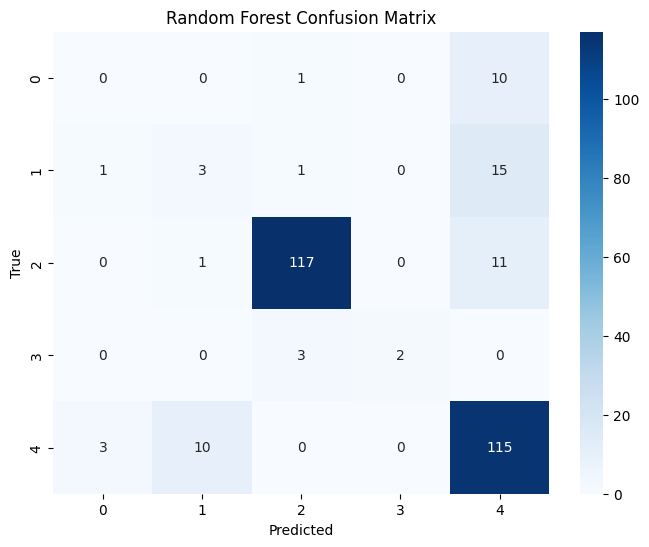

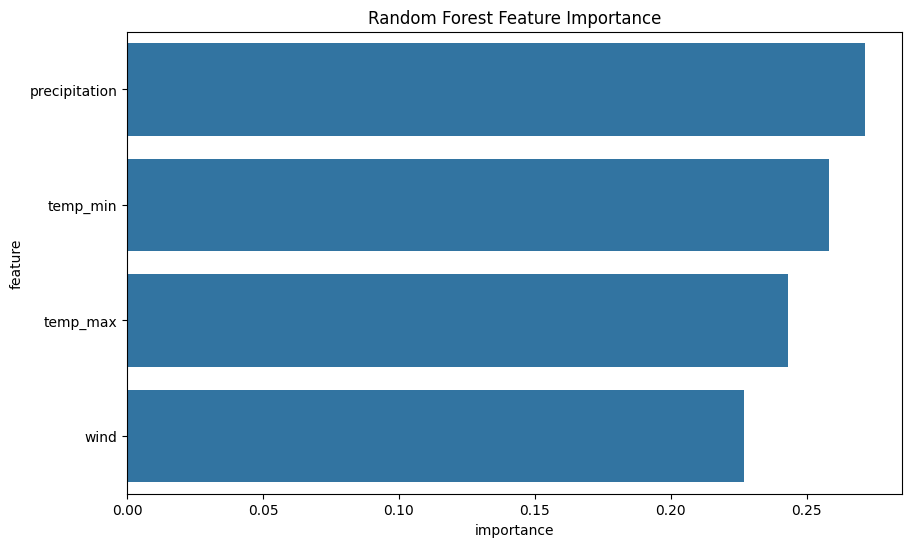


Training XGBoost model...


c:\Users\igpri\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:08:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results:

Classification Report:
              precision    recall  f1-score   support

     drizzle       0.14      0.09      0.11        11
         fog       0.25      0.15      0.19        20
        rain       0.97      0.91      0.94       129
        snow       0.50      0.40      0.44         5
         sun       0.77      0.89      0.82       128

    accuracy                           0.81       293
   macro avg       0.52      0.49      0.50       293
weighted avg       0.79      0.81      0.80       293



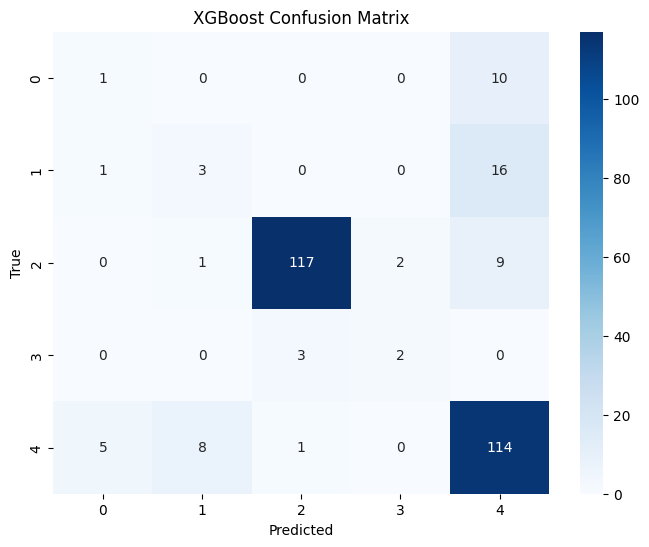


Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 4
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

c:\Users\igpri\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


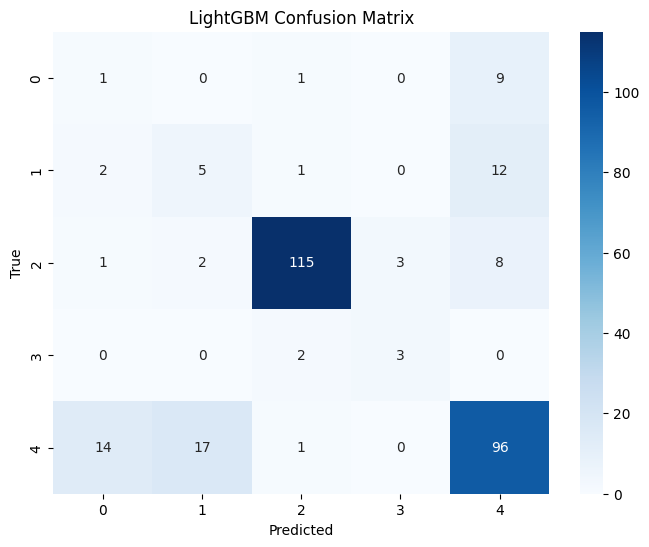

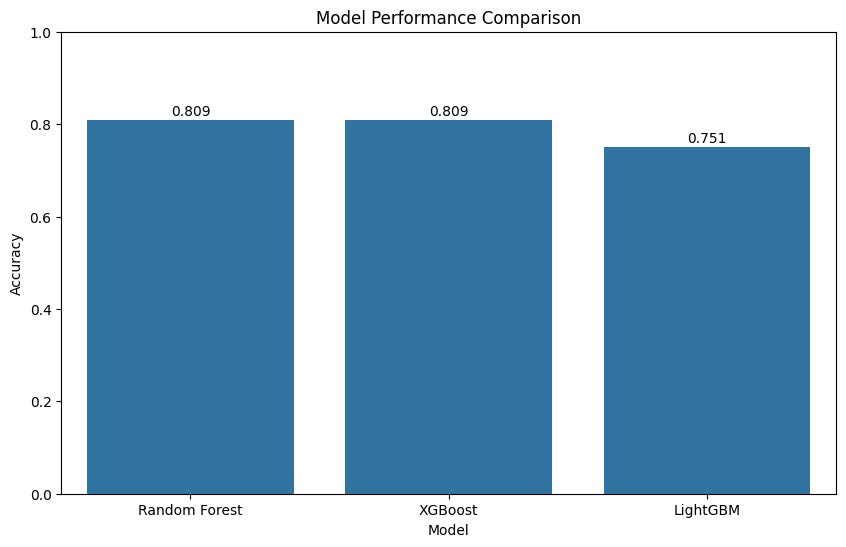


Best performing model: Random Forest with accuracy: 0.809

Class distribution in training set:
weather
sun        0.438356
rain       0.438356
fog        0.069349
drizzle    0.035959
snow       0.017979
Name: proportion, dtype: float64


In [3]:
# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Results:")
    print("\nClassification Report:")
    # Add zero_division=1 to handle classes with no predictions
    print(classification_report(y_true, y_pred, zero_division=1))
    
    # Create confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return accuracy_score(y_true, y_pred)

# Dictionary to store model performances
model_performances = {}

# 1. Random Forest
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, 
                                random_state=42,
                                class_weight='balanced')  # Add class weights
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_accuracy = evaluate_model(y_test, rf_pred, "Random Forest")
model_performances['Random Forest'] = rf_accuracy

# Save Random Forest model
with open('../models/random_forest_weather.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Feature importance plot for Random Forest
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.show()

# 2. XGBoost
print("\nTraining XGBoost model...")
# Convert target labels to numeric format for XGBoost
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Configure XGBoost with better parameters for imbalanced data
xgb_model = xgb.XGBClassifier(
    random_state=42,
    scale_pos_weight=1,  # Helps with class imbalance
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False  # Prevent warning about label encoder
)

# Train XGBoost with encoded labels
xgb_model.fit(X_train_scaled, y_train_encoded)
xgb_pred_encoded = xgb_model.predict(X_test_scaled)
# Convert predictions back to original labels
xgb_pred = le.inverse_transform(xgb_pred_encoded)
xgb_accuracy = evaluate_model(y_test, xgb_pred, "XGBoost")
model_performances['XGBoost'] = xgb_accuracy

# Save XGBoost model and label encoder
with open('../models/xgboost_weather.pkl', 'wb') as f:
    pickle.dump({'model': xgb_model, 'label_encoder': le}, f)

# 3. LightGBM
print("\nTraining LightGBM model...")
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    n_estimators=100,
    learning_rate=0.1
)
lgb_model.fit(X_train_scaled, y_train)
lgb_pred = lgb_model.predict(X_test_scaled)
lgb_accuracy = evaluate_model(y_test, lgb_pred, "LightGBM")
model_performances['LightGBM'] = lgb_accuracy

# Save LightGBM model
with open('../models/lightgbm_weather.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

# Compare model performances
plt.figure(figsize=(10, 6))
performance_df = pd.DataFrame({
    'Model': list(model_performances.keys()),
    'Accuracy': list(model_performances.values())
})

sns.barplot(x='Model', y='Accuracy', data=performance_df)
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
for i, v in enumerate(performance_df['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.show()

# Print best model
best_model = max(model_performances.items(), key=lambda x: x[1])
print(f"\nBest performing model: {best_model[0]} with accuracy: {best_model[1]:.3f}")

# Print class distribution
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))

## Cross-Validation Results
Let's perform k-fold cross-validation to get a more robust estimate of model performance.

Performing cross-validation for Random Forest...
Performing cross-validation for XGBoost...
Performing cross-validation for LightGBM...


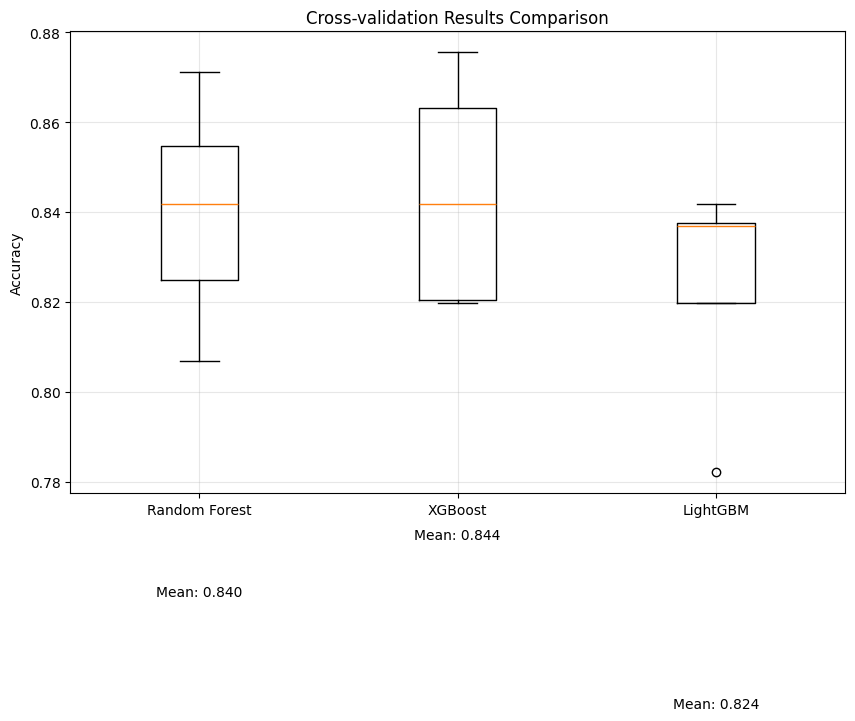


Cross-validation Results:

Random Forest:
Mean accuracy: 0.840
Standard deviation: 0.022
95% confidence interval: ±0.045
Min accuracy: 0.807
Max accuracy: 0.871
Individual fold scores: [0.85470085 0.84188034 0.82478632 0.80686695 0.87124464]

XGBoost:
Mean accuracy: 0.844
Standard deviation: 0.022
95% confidence interval: ±0.045
Min accuracy: 0.820
Max accuracy: 0.876
Individual fold scores: [0.86324786 0.84188034 0.82051282 0.81974249 0.87553648]

LightGBM:
Mean accuracy: 0.824
Standard deviation: 0.022
95% confidence interval: ±0.044
Min accuracy: 0.782
Max accuracy: 0.842
Individual fold scores: [0.83760684 0.84188034 0.78205128 0.81974249 0.83690987]

Detailed cross-validation results saved to '../results/cross_validation_results.csv'

Best model (based on cross-validation): XGBoost
Mean CV Accuracy: 0.844 ± 0.045


In [4]:
# Perform 5-fold cross-validation for each model
cv_results = {}

# Random Forest CV
print("Performing cross-validation for Random Forest...")
rf_cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, 
                             cv=5, scoring='accuracy')
cv_results['Random Forest'] = rf_cv_scores

# XGBoost CV
print("Performing cross-validation for XGBoost...")
# Configure XGBoost for cross-validation without deprecated parameters
xgb_model_cv = xgb.XGBClassifier(
    random_state=42,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100
)
xgb_cv_scores = cross_val_score(xgb_model_cv, X_train_scaled, y_train_encoded, 
                               cv=5, scoring='accuracy')
cv_results['XGBoost'] = xgb_cv_scores

# LightGBM CV
print("Performing cross-validation for LightGBM...")
# Configure LightGBM for cross-validation with proper feature names
lgb_model_cv = lgb.LGBMClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    force_col_wise=True,  # Remove threading overhead warning
    verbose=-1,          # Reduce verbosity
    min_child_samples=20  # Prevent the "no further splits" warning
)

# Create DataFrame for LightGBM to preserve feature names
X_train_df = pd.DataFrame(X_train_scaled, columns=features)
lgb_cv_scores = cross_val_score(lgb_model_cv, X_train_df, y_train, 
                               cv=5, scoring='accuracy')
cv_results['LightGBM'] = lgb_cv_scores

# Create box plot of cross-validation results
plt.figure(figsize=(10, 6))
cv_data = [scores for scores in cv_results.values()]
plt.boxplot(cv_data, tick_labels=list(cv_results.keys()))  # Updated parameter name
plt.title('Cross-validation Results Comparison')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

# Add mean scores with better positioning and formatting
for i, (model, scores) in enumerate(cv_results.items(), 1):
    mean_score = scores.mean()
    min_score = scores.min()
    plt.text(i, min_score - 0.05, f'Mean: {mean_score:.3f}', 
             ha='center', va='top', fontsize=10)

plt.show()

# Print detailed CV results with added information
print("\nCross-validation Results:")
for model, scores in cv_results.items():
    print(f"\n{model}:")
    print(f"Mean accuracy: {scores.mean():.3f}")
    print(f"Standard deviation: {scores.std():.3f}")
    print(f"95% confidence interval: ±{scores.std() * 2:.3f}")
    print(f"Min accuracy: {scores.min():.3f}")
    print(f"Max accuracy: {scores.max():.3f}")
    print(f"Individual fold scores: {scores}")

# Save cross-validation results with additional statistics
cv_stats = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'Mean_Accuracy': [scores.mean() for scores in cv_results.values()],
    'Std_Dev': [scores.std() for scores in cv_results.values()],
    'Min_Accuracy': [scores.min() for scores in cv_results.values()],
    'Max_Accuracy': [scores.max() for scores in cv_results.values()],
    'Fold_Scores': [list(scores) for scores in cv_results.values()]
})

# Save detailed results
cv_stats.to_csv('../results/cross_validation_results.csv', index=False)
print("\nDetailed cross-validation results saved to '../results/cross_validation_results.csv'")

# Identify the best model based on cross-validation
best_model_cv = cv_stats.loc[cv_stats['Mean_Accuracy'].idxmax()]
print(f"\nBest model (based on cross-validation): {best_model_cv['Model']}")
print(f"Mean CV Accuracy: {best_model_cv['Mean_Accuracy']:.3f} ± {best_model_cv['Std_Dev']*2:.3f}")